In [4]:
## the big three
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## +1
import seaborn as sns

## utils
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

## preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

## imputation
from sklearn.impute import KNNImputer

## gridsearch e crossvalidate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

## modelos
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import sklearn
sklearn.set_config(display='diagram')

## Preparação dos dados

In [5]:
df = (
    pd.read_csv('../data/titanic.csv',usecols=['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked'])
    .dropna(subset=['Embarked'],how='any')
    .assign(Age = lambda x: x.Age.fillna(x.Age.mean()))
)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [6]:
col_transf = make_column_transformer(
    
    (MinMaxScaler(),['Age','Fare','SibSp','Parch']),
    (OneHotEncoder(),['Pclass','Sex','Embarked']),
    remainder='passthrough'
)

col_transf

ColumnTransformer(remainder='passthrough',
                  transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['Age', 'Fare', 'SibSp', 'Parch']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['Pclass', 'Sex', 'Embarked'])])

In [7]:
pipe = make_pipeline(col_transf,RandomForestClassifier())

## cross_validate

In [9]:
cross_validate(pipe,df.drop('Survived',axis=1),df.Survived,cv=5,scoring=['accuracy'],return_train_score=True)

{'fit_time': array([0.14856696, 0.13072276, 0.13465786, 0.1201787 , 0.13630033]),
 'score_time': array([0.0148592 , 0.01643324, 0.01565456, 0.01506448, 0.01725125]),
 'test_accuracy': array([0.76404494, 0.79213483, 0.85955056, 0.78651685, 0.84180791]),
 'train_accuracy': array([0.98452883, 0.98734177, 0.98452883, 0.98452883, 0.98174157])}

In [17]:
ls_modelos = [SVC(kernel='linear'),DecisionTreeClassifier(),RandomForestClassifier(),KNeighborsClassifier(),GaussianNB()]
dc = {}

for idx in range(5):
    pipe = make_pipeline(col_transf,ls_modelos[idx])
    results = cross_validate(pipe,df.drop('Survived',axis=1),df.Survived,cv=5,scoring=['accuracy'],return_train_score=True)
    dc[idx] = [results['test_accuracy'].mean(),results['train_accuracy'].mean()]

In [18]:
dc

{0: [0.7862756300387227, 0.7862766478610598],
 1: [0.7705643369516918, 0.9845339686151805],
 2: [0.8110328191455596, 0.9845339686151805],
 3: [0.7918936075668126, 0.857428609807361],
 4: [0.7829365835079033, 0.7888078983549044]}

## GridSearchCV

In [90]:
pipe = make_pipeline(col_transf,RandomForestClassifier())
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Age', 'Fare', 'SibSp',
                                                   'Parch']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('randomforestclassifier', RandomForestClassifier())])

In [92]:
pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('minmaxscaler', MinMaxScaler(),
                                    ['Age', 'Fare', 'SibSp', 'Parch']),
                                   ('onehotencoder', OneHotEncoder(),
                                    ['Pclass', 'Sex', 'Embarked'])])),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('minmaxscaler', MinMaxScaler(),
                                  ['Age', 'Fare', 'SibSp', 'Parch']),
                                 ('onehotencoder', OneHotEncoder(),
                                  ['Pclass', 'Sex', 'Embarked'])]),
 'randomforestclassifier': RandomForestClassifier(),
 'columntransformer__n_jobs': None,
 'columntransformer__remainder': 'passthrough',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__transfo

In [93]:
grid = {'randomforestclassifier__n_estimators':[10,100,200,300,400,500],
 'randomforestclassifier__max_depth':[2,4,6,8,10,12,16],
 'randomforestclassifier__min_samples_leaf':[1,10,15,20,80],
 'columntransformer__minmaxscaler__feature_range':[(0,1),(0,2),(-1,1)]
}

In [94]:
x = df.drop('Survived',axis=1)
y = df.Survived

In [95]:
gcv = GridSearchCV(pipe,param_grid=grid,cv=5,n_jobs=-1,return_train_score=True)
gcv.fit(x,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         ['Age',
                                                                          'Fare',
                                                                          'SibSp',
                                                                          'Parch']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'Embarked'])])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'columntransformer__minmaxscaler__feature_range': [(0,
                                                                             1),
                                                                            (0,
                                                                             2),
                                                                            (-1,
                                                                             1)],
                         'randomforestclassifier__max_depth': [2, 4, 6, 8, 10,
                                                               12, 16],
                         'randomforestclassifier__min_samples_leaf': [1, 10, 15,
                                                                      20, 80],
                         'randomforestclassifier__n_estimators': [10, 100, 200,
                                                                  300, 400,
                                                                  500]},
             return_train_score=True)

In [98]:
gcv.best_params_

{'columntransformer__minmaxscaler__feature_range': (0, 2),
 'randomforestclassifier__max_depth': 12,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__n_estimators': 300}

In [100]:
gcv.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(feature_range=(0,
                                                                              2)),
                                                  ['Age', 'Fare', 'SibSp',
                                                   'Parch']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=12, n_estimators=300))])

In [115]:
results_df = pd.DataFrame.from_dict(gcv.cv_results_)

<AxesSubplot:xlabel='param_randomforestclassifier__max_depth', ylabel='param_randomforestclassifier__min_samples_leaf'>

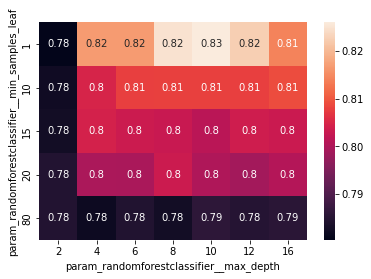

In [116]:
sns.heatmap((
    results_df[['param_randomforestclassifier__min_samples_leaf','param_randomforestclassifier__max_depth','mean_test_score']]
    .pivot_table(index='param_randomforestclassifier__min_samples_leaf',columns='param_randomforestclassifier__max_depth',values='mean_test_score',aggfunc='mean')
),annot=True)

In [119]:
(
    results_df[['param_randomforestclassifier__min_samples_leaf','param_randomforestclassifier__max_depth','mean_test_score']]
    .pivot_table(index='param_randomforestclassifier__min_samples_leaf',columns='param_randomforestclassifier__max_depth',values='mean_test_score',aggfunc='mean')
)

param_randomforestclassifier__max_depth,2,4,6,8,10,12,16
param_randomforestclassifier__min_samples_leaf,,,,,,,
1,0.780410,0.816600,0.816609,0.824739,0.825932,0.822431,0.814117
10,0.782345,0.804716,0.807714,0.807841,0.807966,0.807779,0.808900
15,0.782592,0.804342,0.803218,0.802904,0.801283,0.803530,0.803095
20,0.784590,0.799716,0.799592,0.803276,0.800093,0.798844,0.800657
80,0.784588,0.781968,0.784339,0.782656,0.785775,0.784963,0.785465


<a list of 7 text.Text objects>

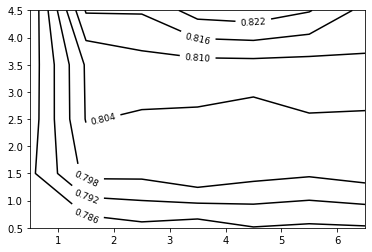

In [123]:
f, ax = plt.subplots()
cs = ax.contour((
    results_df[['param_randomforestclassifier__min_samples_leaf','param_randomforestclassifier__max_depth','mean_test_score']]
    .pivot_table(index='param_randomforestclassifier__min_samples_leaf',columns='param_randomforestclassifier__max_depth',values='mean_test_score',aggfunc='mean')
),colors='k',origin='upper')

ax.clabel(cs, fontsize=9, inline=True)